# Utils

In [39]:
import warnings
import umap
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from panel.io.handlers import display
from sklearn.cluster import KMeans
import hdbscan
from scipy.stats import chi2_contingency
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt


warnings.simplefilter(action='ignore', category=FutureWarning)

from analysis import utils, clustering_evaluation, clustering, plotting
from preprocessing import processflat

importlib.reload(clustering_evaluation)
importlib.reload(clustering)
importlib.reload(processflat)
importlib.reload(plotting)
importlib.reload(utils)

from preprocessing.processflat import x_features_return
from analysis.clustering import plot_clusters_vs_groups
from analysis.plotting import plot_umap_embedding
from analysis.utils import run_umap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# FC maps directories
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps_processed = '/data/FCmaps_augmented_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"

# Path to masks
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/mask_GM.nii'

# Metadata
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/atrophy_matched.xlsx'
cognitive_dataset ='/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/cognitive_dataset.xlsx'
path_df_meta = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/meta/df_meta.csv"

# Done dataframe of preprocessed FC maps
path_df_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_gm.pkl"
path_df_thr02_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_thr02_gm.pkl"

# Umap

## Input Data

For the further analysis we will remove the ID labels columns, but the order is maintained.

Possible dataset from mean maps:
- `df_thr01_gm_masked`
- `df_thr02_gm_masked`
- `df_thr01_har_masked`
- `df_thr02_har_masked`
- `df_gm_masked`
- `df_har_masked`

Possible dataset from mean network:
- `df_networks_no_thr`
- `df_networks_thr01`
- `df_networks_thr02`

Here we go with one example

In [41]:
# Load dataframes
df_gm = pd.read_pickle(path_df_gm)
df_meta = pd.read_csv(path_df_meta)

# Merge with metadata
df_merged, X = x_features_return(df_gm, df_meta)


-------------------- Dataset Info --------------------
Meta columns (Labels and Covariates):       10
Feature matrix shape (X):                (176, 161817)
Complete dataframe shape after merge:    (176, 161827)
-------------------------------------------------------



## Dimensionality Reduction

UMAP is not changing the order of the rows so each row correspond to the previous subject in the not reduced dataset.

In [42]:
np.random.seed(42)

In [43]:
# Parameters
umap_params = {'n_neighbors': 15, 'n_components': 2, 'metric': 'euclidean', 'n_epochs': 1000, 'learning_rate': 1.0, 'init': 'spectral', 'min_dist': 0.1, 'spread': 1.0, 'low_memory': False, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'a': None, 'b': None, 'random_state': 42, 'metric_kwds': None, 'angular_rp_forest': False, 'target_n_neighbors': -1, 'transform_seed': 42, 'verbose': False, 'unique': False}
reducer = umap.UMAP(**umap_params)

# Fit the model
X_umap = reducer.fit_transform(X)

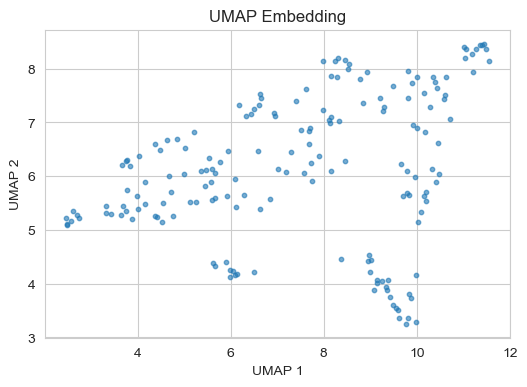

In [44]:
plt.figure(figsize=(6, 4))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6)
plt.title("UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

In [45]:
pls = PLSRegression(n_components=X_umap.shape[1])
pls.fit(X_umap, X)
X_pred = pls.predict(X_umap)

# Calcola R²: frazione di varianza spiegata da UMAP
umap_variance_explained = r2_score(X, X_pred, multioutput='variance_weighted')
print(f"UMAP explained variance (R²): {umap_variance_explained:.3f}")

UMAP explained variance (R²): 0.613


In [46]:
max_comps = X_umap.shape[1]
cumulative_r2 = []

for i in range(1, max_comps + 1):
    pls = PLSRegression(n_components=i)
    pls.fit(X_umap[:, :i], X)
    X_pred = pls.predict(X_umap[:, :i])
    r2 = r2_score(X, X_pred, multioutput='variance_weighted')
    cumulative_r2.append(r2)
    print(f"Variance explained by first {i} UMAP components: R² = {r2:.4f}")

Variance explained by first 1 UMAP components: R² = 0.5082
Variance explained by first 2 UMAP components: R² = 0.6131


In [38]:
# Parameters
umap_params = {'n_neighbors': 15, 'n_components': 30, 'metric': 'euclidean', 'n_epochs': 1000, 'learning_rate': 1.0, 'init': 'spectral', 'min_dist': 0.1, 'spread': 1.0, 'low_memory': False, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'a': None, 'b': None, 'random_state': 42, 'metric_kwds': None, 'angular_rp_forest': False, 'target_n_neighbors': -1, 'transform_seed': 42, 'verbose': False, 'unique': False}
reducer = umap.UMAP(**umap_params)

# Fit the model
X_umap_example = reducer.fit_transform(X)

# Variance
max_comps = X_umap_example.shape[1]
cumulative_r2 = []

for i in range(1, max_comps + 1):
    pls = PLSRegression(n_components=i)
    pls.fit(X_umap_example[:, :i], X)
    X_pred = pls.predict(X_umap_example[:, :i])
    r2 = r2_score(X, X_pred, multioutput='variance_weighted')
    cumulative_r2.append(r2)

# Plot
plt.plot(range(1, max_comps + 1), cumulative_r2, marker='o')
plt.xlabel('Number of UMAP components')
plt.ylabel('Explained variance (R²)')
plt.title('Cumulative variance explained by UMAP components')
plt.grid(True)
plt.tight_layout()
plt.show()


KeyboardInterrupt



## Fit models

In [47]:
# HDBSCAN
cluster_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = cluster_hdb.fit_predict(X_umap)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
labels_km = kmeans.fit_predict(X_umap)

Result collection

In [48]:
labels_dict = {
    "HDBSCAN": labels_hdb,
    "K-Means": labels_km,
}

labels_df = pd.DataFrame({
    'ID': df_merged['ID'],
    'X1': X_umap[:, 0],
    'X2': X_umap[:, 1],
    'Group': df_merged['Group'],
    'CDR_SB': df_merged['CDR_SB'],
    'MMSE': df_merged['MMSE'],
    'labels_gmm_cdr': df_merged['labels_gmm_cdr'],
    'HDBSCAN': labels_hdb,
    'KMeans': labels_km,
})


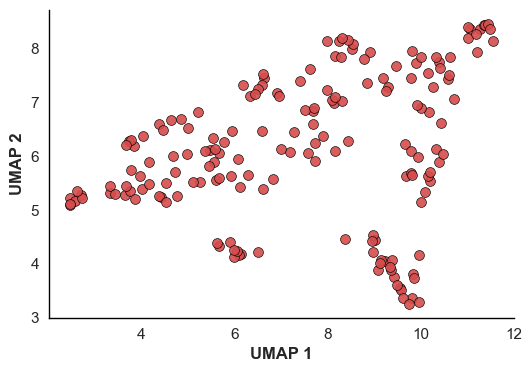

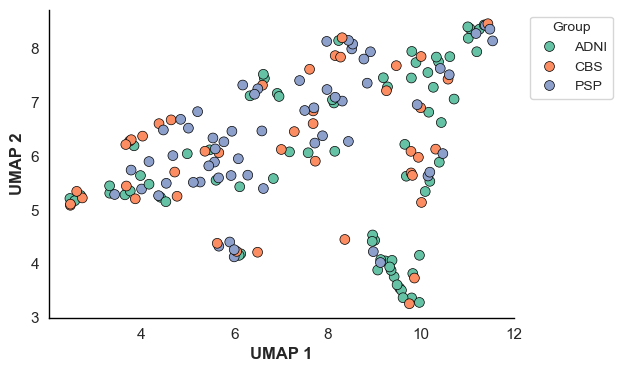

In [49]:
plot_umap_embedding(
        labels_df,
        title=None,
        save_path=None,
        plot_flag=True,
        save_flag=False,
        color_by_group= True,
        group_column= "Group"
    )

## Statistical Evaluation

In [54]:
freq_assolute = pd.crosstab(labels_df['KMeans'], labels_df['Group'], margins=True)
freq_assolute.index.name = 'Cluster'
freq_assolute.columns.name = None

freq_col = pd.crosstab(labels_df['KMeans'], labels_df['Group'], normalize='columns') * 100
freq_col = freq_col.round(2)
freq_col.index.name = 'Cluster'
freq_col.columns.name = None

freq_row = pd.crosstab(labels_df['KMeans'], labels_df['Group'], normalize='index') * 100
freq_row = freq_row.round(2)
freq_row.index.name = 'Cluster'
freq_row.columns.name = None

freq_tot = pd.crosstab(labels_df['KMeans'], labels_df['Group'])
freq_tot = (freq_tot / freq_tot.values.sum()) * 100
freq_tot = freq_tot.round(2)
freq_tot.index.name = 'Cluster'
freq_tot.columns.name = None


In [57]:
print("\nTabella A – Frequenze assolute")
print(freq_assolute)

print("\nTabella B – % rispetto al gruppo diagnostico (colonna)")
print(freq_col)

print("\nTabella C – % rispetto al cluster (riga)")
print(freq_row)

print("\nTabella D – % sul totale dei soggetti")
print(freq_tot)


Tabella A – Frequenze assolute
         ADNI  CBS  PSP  All
Cluster                     
0          25   17   24   66
1          25   21   32   78
2          22    6    4   32
All        72   44   60  176

Tabella B – % rispetto al gruppo diagnostico (colonna)
          ADNI    CBS    PSP
Cluster                     
0        34.72  38.64  40.00
1        34.72  47.73  53.33
2        30.56  13.64   6.67

Tabella C – % rispetto al cluster (riga)
          ADNI    CBS    PSP
Cluster                     
0        37.88  25.76  36.36
1        32.05  26.92  41.03
2        68.75  18.75  12.50

Tabella D – % sul totale dei soggetti
         ADNI    CBS    PSP
Cluster                    
0        14.2   9.66  13.64
1        14.2  11.93  18.18
2        12.5   3.41   2.27


In [58]:
from scipy.stats import chi2_contingency

# Tabella di contingenza grezza (senza margini)
contingency = pd.crosstab(labels_df['KMeans'], labels_df['Group'])

# Test chi-quadrato
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi2 statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.4f}")


Chi2 statistic: 13.91
Degrees of freedom: 4
P-value: 0.0076


Gli adjusted Pearson residuals (residui di Pearson aggiustati) sono una versione standardizzata dei residui di Pearson che tiene conto della variabilità attesa in ciascuna cella di una tabella di contingenza. Questi valori sono distribuiti come una normale standard (𝑁(0,1)), il che permette di valutare quali celle si discostano significativamente da quanto atteso sotto l’ipotesi di indipendenza tra le variabili:

* $|z| > 1.96$ → fuori dall'intervallo ±1.96 → al di fuori del **95.45%** → **p < 0.05**
* $|z| > 2.58$ → fuori dall'intervallo ±2.58 → al di fuori del **99%** → **p < 0.01**
* $|z| > 3.29$ → fuori dall'intervallo ±3.29 → al di fuori del **99.9%** → **p < 0.001**


In [59]:
# Margini
obs = contingency.values
rows_sum = obs.sum(axis=1).reshape(-1, 1)  # somma delle righe
cols_sum = obs.sum(axis=0).reshape(1, -1)  # somma delle colonne
total = obs.sum()

p_row = rows_sum / total
p_col = cols_sum / total

# Calcolo degli adjusted Pearson residuals
adj_residuals = (obs - expected) / np.sqrt(expected * (1 - p_row) * (1 - p_col))

# Conversione in DataFrame con stesso index/columns della tabella originale
adj_res_df = pd.DataFrame(adj_residuals, index=contingency.index, columns=contingency.columns)

print("\nAdjusted Pearson Residuals (Z-score-like):")
print(adj_res_df.round(2))


Adjusted Pearson Residuals (Z-score-like):
Group   ADNI   CBS   PSP
KMeans                  
0      -0.63  0.18  0.49
1      -2.13  0.53  1.73
2       3.54 -0.90 -2.85


L’Adjusted Rand Index (ARI) misura quanto il clustering coincide con le etichette vere, confrontando tutte le coppie di soggetti: se due soggetti sono nello stesso gruppo sia nel clustering che nelle etichette vere (o in gruppi diversi in entrambi), è un accordo.
- ARI = 1: clustering perfetto
- ARI ≈ 0: clustering casuale
- ARI < 0: peggio del caso

In [53]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(labels_df['Group'], labels_df['KMeans'])
print("Adjusted Rand Index:", round(ari, 3))

Adjusted Rand Index: 0.011
